# Redo small color patch model 

Based on DF_Filter.017  

Tried data augmentation but gave up
Data augmentation ideas (https://keras.io/examples/vision/image_classification_from_scratch/)  
That page recommends preprocessing the data for CPU computing.  
It recommends adding a layer to the model for GPU computing.  
But model.save failes when we include that layer.   

Directory structure is
* cache/train/{black,green,blue}
* cache/valid/{black,green,blue}
* Totals are {3930,2946,3410}
* Train/Valid split is 80:20.

Filename like F15.209.png would be patches of F15.DF1.135.tif  
Filename like h7_.62.png  would be patches of H7.DF1.62.tif by coincidence  
All prefixes are 3 characters.  
Each patch file holds a 224x224 patch of a color image.

In [1]:
import time
import os
#  os.environ['CUDA_VISIBLE_DEVICES'] = "0"   # turns off GPU?
import glob
import cv2 # OpenCV-Python
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import json
from tensorflow import keras
import keras.layers as kl
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
DIR_IMAGES_IN = "/home/jrm/Martinez/images/training/"  # was named cache
PATCH_SIZE=224  # matches VGG
DIR_MODELS = "/home/jrm/Martinez/models/"
FILE_MODEL = "CNN_SMALL_REDO"
filepath=DIR_MODELS+FILE_MODEL
print("Will overwrite model at "+filepath)

Will overwrite model at /home/jrm/Martinez/models/CNN_SMALL_REDO


In [3]:
train_dir = os.path.join(DIR_IMAGES_IN, 'train')
valid_dir = os.path.join(DIR_IMAGES_IN, 'valid')

BATCH_SIZE = 32
IMG_SIZE = (224,224)

train_dataset = keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_dataset = keras.utils.image_dataset_from_directory(
    valid_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 13435 files belonging to 3 classes.
Found 3358 files belonging to 3 classes.


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.


In [4]:
# Normalize color channel ints to floats (0,1)
# See https://www.tensorflow.org/tutorials/load_data/images

normalization_layer = kl.Rescaling(1.0/255.0)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))

In [5]:
iterator = valid_dataset.take(1)
for x in iterator:
    print(x[0].shape)
    print(x[1])

(32, 224, 224, 3)
tf.Tensor([0 0 0 0 0 0 0 0 0 2 1 2 0 0 0 0 0 2 2 0 0 1 2 2 0 0 2 0 0 0 2 0], shape=(32,), dtype=int32)


In [6]:
ACTIVATION="tanh"
NUM_CLASSES = 3
CHANNELS=3
INPUT_SHAPE=[PATCH_SIZE,PATCH_SIZE,CHANNELS]
cnn = keras.models.Sequential([
    #kl.RandomFlip(),
    kl.Conv2D(64,5,activation=ACTIVATION,padding="SAME",input_shape=INPUT_SHAPE),
    kl.MaxPooling2D(2),
    kl.Conv2D(64,5,activation=ACTIVATION,padding="same"),
    kl.Conv2D(64,5,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2),   
    kl.Conv2D(64,5,activation=ACTIVATION,padding="same"),
    kl.Conv2D(64,5,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2), 
    kl.Flatten(),
    kl.Dense(32,activation=ACTIVATION),
    kl.Dropout(0.5),
    kl.Dense(16,activation=ACTIVATION),
    kl.Dropout(0.5),    
    kl.Dense(NUM_CLASSES,activation="softmax")
])


In [7]:
cnn.compile(loss="sparse_categorical_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
EPOCHS=5
start = time.time()
hist = cnn.fit(train_dataset,validation_data=valid_dataset,epochs=EPOCHS)
end = time.time()
print("Elapsed time:",end-start)

Epoch 1/5
420/420 [==============================] - 30s 66ms/step - loss: 0.1441 - accuracy: 0.9667 - val_loss: 0.0110 - val_accuracy: 0.9988
Epoch 2/5
420/420 [==============================] - 27s 64ms/step - loss: 0.0771 - accuracy: 0.9827 - val_loss: 0.0052 - val_accuracy: 0.9991
Epoch 3/5
420/420 [==============================] - 27s 64ms/step - loss: 0.0457 - accuracy: 0.9923 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 4/5
420/420 [==============================] - 27s 64ms/step - loss: 0.0353 - accuracy: 0.9934 - val_loss: 0.0023 - val_accuracy: 0.9994
Epoch 5/5
420/420 [==============================] - 27s 64ms/step - loss: 0.0312 - accuracy: 0.9954 - val_loss: 0.0025 - val_accuracy: 0.9994
Elapsed time: 138.43318367004395


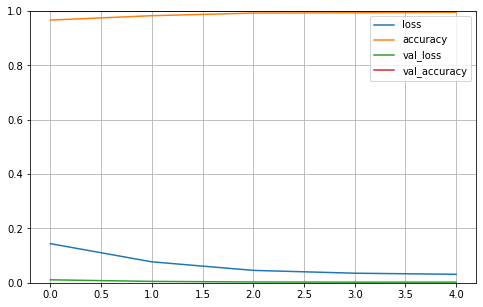

In [8]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.0,1.0)
plt.show()

In [9]:
cnn.save(filepath)

INFO:tensorflow:Assets written to: /home/jrm/Martinez/models/CNN_SMALL_REDO/assets


2022-02-22 12:37:17.960251: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 7.87M (8255232 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory

2022-02-22 12:37:17.960302: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8B (rounded to 256)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 

Current allocation summary follows.

2022-02-22 12:37:17.960326: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc

2022-02-22 12:37:17.960347: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.

2022-02-22 12:37:17.960366: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.

2022-02-22 12:37:17.960383: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (1024): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.

2022-02-22 12:37:17.960412: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (2048): 	Total Chunks: 1, Chunks in use: 1. 2.2KiB allocated for chunks. 2.2KiB in use in bin. 1.0KiB client-requested in use in bin.

2022-02-22 12:37:17.960431: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (4096): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.